In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import transformers
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()
pd.set_option('display.max_columns',None)
print(f'TF version: {tf.__version__}')
print(f'transformers version: {transformers.__version__}')

TF version: 2.6.4
transformers version: 4.20.1


In [2]:
'''
VERSION: 1
DESC: Deberta v3 with tensorflow, default CFG
'''
DEBERTA_MODEL="../input/debertav3base"
DATA_PATH="../input/feedback-prize-english-language-learning/"

In [3]:
#Reading data
df_modeling = pd.read_csv(DATA_PATH+"train.csv")
df_sub = pd.read_csv(DATA_PATH+"test.csv")
df_train, df_test = train_test_split(df_modeling,test_size=0.20, random_state=123)

In [4]:
#Useful functions
def inputfromDF(df):
    X = df['full_text']
    Y1 = df['cohesion']
    Y2 = df['syntax']
    Y3 = df['vocabulary']
    Y4 = df['phraseology']
    Y5 = df['grammar']
    Y6 = df['conventions']
    return X, Y1, Y2, Y3, Y4, Y5, Y6

#Roundoff prediction score to nearest multiple of 0.5
def roundoffScore(n):
    x1=math.floor(n)
    if n>x1+0.75:
        return x1+1.0
    elif n>x1+0.25:
        return x1+0.5
    else:
        return x1

#Mean of Root Mean Squared Error of multiple targets
def MCRMSE(y_test, y_pred):
    mse_list=[]
    target_names = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    for i in range(y_test.shape[1]):
        mse_list.append(mean_squared_error(y_test[:,i], y_pred[:,i]))
        print("MSE for {} : {:.4f}".format(target_names[i], mean_squared_error(y_test[:,i], y_pred[:,i])))
    return sum(mse_list)/y_test.shape[1]

#Data encoder to tokenize input text for input of deberta
tokenizer = transformers.AutoTokenizer.from_pretrained(DEBERTA_MODEL)
def data_encoder(df,column,tokenizer=tokenizer,MAX_LENGTH=512, return_labels=True):
    text_array=df[column].tolist()
    input_ids, attention_masks = [], []
    for i in text_array:
        token=tokenizer(i,add_special_tokens=True, max_length=MAX_LENGTH, return_attention_mask=True, return_tensors="np", truncation=True, padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_masks.append(token['attention_mask'][0])
    if return_labels:
        labels = np.array(df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]])
        return np.array(input_ids, dtype="int32"), np.array(attention_masks, dtype="int32"), labels
    else:
        return np.array(input_ids, dtype="int32"), np.array(attention_masks, dtype="int32")

#Training tf dataset generator
def get_train_dataset(ids, mask, y):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    y = tf.data.Dataset.from_tensor_slices((
        tf.constant(y[:, 0], dtype="int32"),
        tf.constant(y[:, 1], dtype='int32'),
        tf.constant(y[:, 2], dtype='int32'),
        tf.constant(y[:, 3], dtype='int32'),
        tf.constant(y[:, 4], dtype='int32'),
        tf.constant(y[:, 5], dtype='int32'),
    ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = tf.data.Dataset.zip((x, y))
    data = data.with_options(options)
    data = data.repeat()
    data = data.shuffle(BUFFER_SIZE)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Validation tf dataset generator
def get_val_dataset(ids, mask, y):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    y = tf.data.Dataset.from_tensor_slices((
        tf.constant(y[:, 0], dtype="int32"),
        tf.constant(y[:, 1], dtype='int32'),
        tf.constant(y[:, 2], dtype='int32'),
        tf.constant(y[:, 3], dtype='int32'),
        tf.constant(y[:, 4], dtype='int32'),
        tf.constant(y[:, 5], dtype='int32'),
    ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = tf.data.Dataset.zip((x, y))
    data = data.with_options(options)
    data = data.repeat()
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Prediction tf dataset generator
def get_pred_dataset(ids, mask):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = x
    data = data.with_options(options)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Meanpool layer required in deberta
class MeanPool(tf.keras.layers.Layer):
    def call(self, x, mask=None):
        broad_mask = tf.cast(tf.expand_dims(mask, -1), "float32")
        x = tf.math.reduce_sum( x * broad_mask, axis=1)
        x = x / tf.math.maximum(tf.reduce_sum(broad_mask, axis=1), tf.constant([1e-9]))
        return x

/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [5]:
#Model building using deberta and Keras Functional API
def build_model(trainable=True):
    tf.keras.backend.clear_session()
    
    input1 = tf.keras.Input(shape=(None,), dtype="int32", name="input_ids")
    input2 = tf.keras.Input(shape=(None,), dtype="int32", name="attention_mask")
    base_model = transformers.TFAutoModel.from_pretrained(DEBERTA_MODEL)
    base_model.trainable = trainable
    base_outputs = base_model.deberta({"input_ids": input1,"attention_mask": input2})
    last_hidden_state = base_outputs[0]
    x = MeanPool()(last_hidden_state, mask=input2)
    
    x1 = tf.keras.layers.Dense(units=16, activation='relu',kernel_initializer='he_normal')(x)
    output1 = tf.keras.layers.Dense(units='1')(x1)
    x2 = tf.keras.layers.Dense(units=16, activation='relu',kernel_initializer='he_normal')(x)
    output2 = tf.keras.layers.Dense(units='1')(x2)
    x3 = tf.keras.layers.Dense(units=16, activation='relu',kernel_initializer='he_normal')(x)
    output3 = tf.keras.layers.Dense(units='1')(x3)
    x4 = tf.keras.layers.Dense(units=16, activation='relu',kernel_initializer='he_normal')(x)
    output4 = tf.keras.layers.Dense(units='1')(x4)
    x5 = tf.keras.layers.Dense(units=16, activation='relu',kernel_initializer='he_normal')(x)
    output5 = tf.keras.layers.Dense(units='1')(x5)
    x6 = tf.keras.layers.Dense(units=16, activation='relu',kernel_initializer='he_normal')(x)
    output6 = tf.keras.layers.Dense(units='1')(x6)
    
    model = tf.keras.Model(inputs={"input_ids": input1,"attention_mask": input2}, outputs= [output1,output2,output3,output4,output5,output6])
    return model

In [53]:
BATCH_SIZE = 4
BUFFER_SIZE = 3200
AUTO = tf.data.AUTOTUNE
steps_per_epoch = df_train.shape[0]//BATCH_SIZE
validation_steps = df_test.shape[0]//BATCH_SIZE

In [54]:
input_train=data_encoder(df_train,'full_text',tokenizer=tokenizer,MAX_LENGTH=512,return_labels=True)
input_test=data_encoder(df_test,'full_text',tokenizer=tokenizer,MAX_LENGTH=512,return_labels=True)
input_sub=data_encoder(df_sub,'full_text',tokenizer=tokenizer,MAX_LENGTH=512,return_labels=False)

In [55]:
train_dataset = get_train_dataset(input_train[0], input_train[1], input_train[2])
test_dataset = get_val_dataset(input_test[0], input_test[1], input_test[2])
test_dataset_wo_label = get_pred_dataset(input_test[0], input_test[1])
sub_dataset = get_pred_dataset(input_sub[0], input_sub[1])

In [56]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,mode="auto",min_delta=0.00001,min_lr=0.00001)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.00001,patience=5,mode="auto",restore_best_weights=True)

In [57]:
#Initiate model object and its architecture
model=build_model()
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


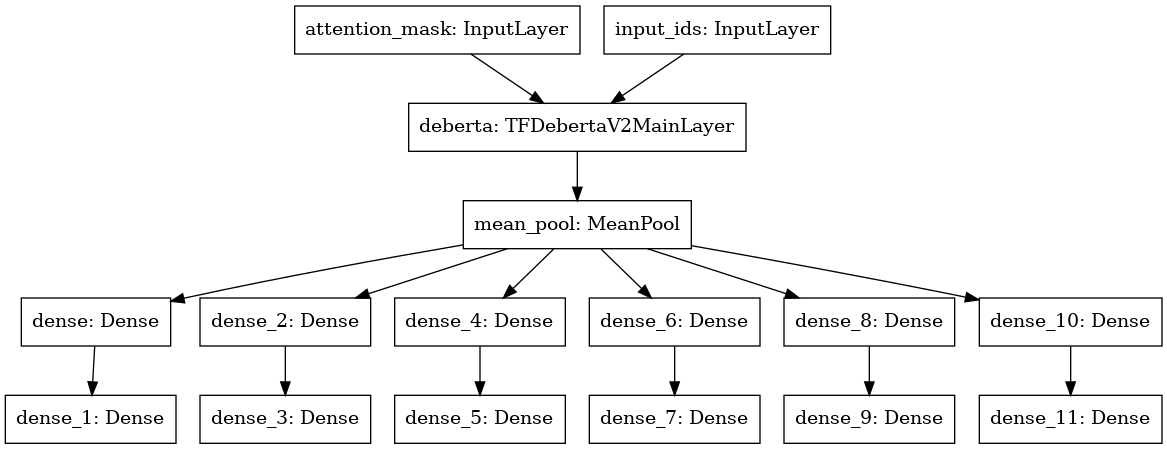

In [58]:
#Visualize Model Structure
tf.keras.utils.plot_model(model)

In [76]:
#Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
deberta (TFDebertaV2MainLayer)  TFBaseModelOutput(la 183831552   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
mean_pool (MeanPool)            (None, 768)          0           deberta[0][0]                

In [59]:
#Model training
t1=datetime.datetime.now()
out = model.fit(train_dataset,validation_data=test_dataset,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,callbacks=[reduceLR,es],epochs=3,verbose=1)
print("#"*100)
print("Total time taken: ", datetime.datetime.now()-t1)

Epoch 1/3
782/782 [==============================] - 654s 778ms/step - loss: 5.8756 - dense_1_loss: 1.3091 - dense_3_loss: 0.7001 - dense_5_loss: 0.5856 - dense_7_loss: 0.6213 - dense_9_loss: 1.8497 - dense_11_loss: 0.8097 - dense_1_mean_squared_error: 1.3091 - dense_3_mean_squared_error: 0.7001 - dense_5_mean_squared_error: 0.5856 - dense_7_mean_squared_error: 0.6213 - dense_9_mean_squared_error: 1.8497 - dense_11_mean_squared_error: 0.8097 - val_loss: 2.8999 - val_dense_1_loss: 0.4821 - val_dense_3_loss: 0.4695 - val_dense_5_loss: 0.3904 - val_dense_7_loss: 0.5206 - val_dense_9_loss: 0.5195 - val_dense_11_loss: 0.5178 - val_dense_1_mean_squared_error: 0.4821 - val_dense_3_mean_squared_error: 0.4695 - val_dense_5_mean_squared_error: 0.3904 - val_dense_7_mean_squared_error: 0.5206 - val_dense_9_mean_squared_error: 0.5195 - val_dense_11_mean_squared_error: 0.5178
Epoch 2/3
782/782 [==============================] - 601s 768ms/step - loss: 3.2308 - dense_1_loss: 0.5881 - dense_3_loss: 0.

In [60]:
#Making prediction on test dataset
Y_pred = model.predict(test_dataset_wo_label)

In [63]:
_, Y1_test, Y2_test, Y3_test, Y4_test, Y5_test, Y6_test = inputfromDF(df_test)
Y_test = np.vstack([Y1_test, Y2_test, Y3_test, Y4_test, Y5_test, Y6_test]).T
Y_pred1 = np.vstack([roundoffScore(j) for j in i] for i in np.hstack([x for x in Y_pred]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
#Category wise RMSE for each target
MCRMSE(Y_test, Y_pred1)

MSE for cohesion : 0.4419
MSE for syntax : 0.6130
MSE for vocabulary : 0.3771
MSE for phraseology : 0.4390
MSE for grammar : 0.4777
MSE for conventions : 0.4323


0.463495104299702

### Prediction on unseen data

In [71]:
Y_pred_sub = model.predict(sub_dataset)

In [72]:
Y_pred_sub1 = np.vstack([roundoffScore(j) for j in i] for i in np.hstack([x for x in Y_pred_sub]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [73]:
df_sub['cohesion'] = Y_pred_sub1[:,0]
df_sub['syntax'] = Y_pred_sub1[:,1]
df_sub['vocabulary']= Y_pred_sub1[:,2]
df_sub['phraseology']= Y_pred_sub1[:,3]
df_sub['grammar']= Y_pred_sub1[:,4]
df_sub['conventions']= Y_pred_sub1[:,5]

In [77]:
#Unseen data prediction
df_sub.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.0,3.5,3.5,3.0,3.0,3.0
1,000BAD50D026,Do you think students would benefit from being...,3.0,3.5,3.5,3.0,3.0,3.0
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.0,3.5,3.5,3.0,3.0,3.0


In [75]:
df_sub.drop(columns=['full_text']).to_csv("predictions.csv",index=False)